# Visualising tomographic consensus in the lower-mantle à la Cottaar and Lekic (GJI, 2016)

Seismic tomography provides images of the interior of the planet.  As computing power, expertise, and the increasing availability of high quality seismic data has increased we are seeing higher resolution images of the velocity structure inside the Earth.  [Cottaar and Lekic (2016)](http://doi.org/10.1093/gji/ggw324) look at a suite of recent models and use clustering to automatically interpret regions inside planets as "fast", "neutral", or "slow" in terms of the speed at which seismic waves propagate through.  In a sense each model votes as to whether a particular point is "fast", "neutral", or "slow".  They then tally up the votes at each location to see how well the models agree.

In the lower mantle vast [continental scale features](http://www.nature.com/ngeo/journal/v9/n7/abs/ngeo2733.html) dominate the landscape.  These are characterised by slow seismic velocities and pose an interesting scientific problem: What are they?  Are they hot?  Are they made of different "stuff" to the surroundings?  What role do they play in the Earth's dynamics?  

By looking at consensus regions where models agree that the Earth is slower than normal to seismic waves, we get a picture of what these features _might_ actually look like.


Here I take the data from [Ved Lekic's website](https://www.geol.umd.edu/facilities/seismology/data/morphology-of-lower-mantle-structures/) and show how to plot it up using Python and how to spin it around in 3-D using Paraview.  Hopefully this will be useful to someone wanting to look at the models and spin them around for themselves.


## Preliminaries


You will need to import a few things within python.


In [2]:
# top line probably not needed unless working in Jupyter notebook
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 8

## Read the data

Assuming you have downloaded the [data](https://www.geol.umd.edu/facilities/seismology/data/morphology-of-lower-mantle-structures/) you can simply read it in using numpy's very handy genfromtxt.  Easy as that!

In [2]:
votes = np.genfromtxt('Morphology_Models_CottaarLekic2016/cluster_votes_Vs_CottaarLekic2016.txt',
                      dtype=None)

## Colour bar

Cottaar and Lekic devise a pretty cool colour bar based on a triangle with red-yellow-blue at each of the corners.  The strength of the reds/blues/yellows corresponds to the strength of consensus amongst the various tomographic models for slow/fast/neutral regions respectively.  Muddier colours show disagreement amongst models.  If you're interested in how it works I recommend studying Figure 1 in the [paper](http://doi.org/10.1093/gji/ggw324).

This code shows how to take a list of RGB values (contained in the colortriangle.cpt ) and to convert it to a colourbar that can be used in python.

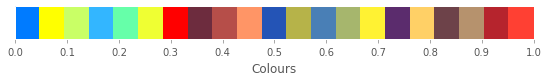

In [21]:
# read colour map to list

# I copied the colourbar data into a file I called "colortriangle.cpt"
rgb = np.genfromtxt('Morphology_Models_CottaarLekic2016/colortriangle.cpt',dtype=None)
cm = mpl.colors.ListedColormap(rgb.tolist())

# have a look
fig = plt.figure(figsize=(8, 3))
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cm,
                                orientation='horizontal')
cb1.set_label('Colours')

plt.show()

## Map

Here I show how to plot a depth slice in map view.  Note this is virtually identical to the map shown in the bottom left panel in Figure 2 in the [paper](http://doi.org/10.1093/gji/ggw324).

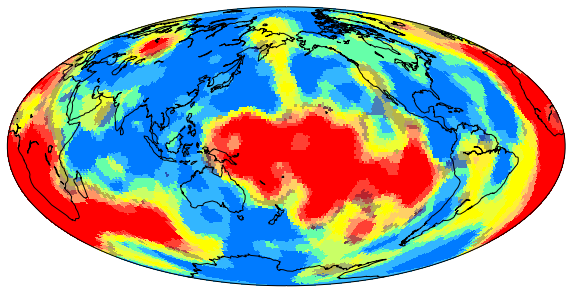

In [23]:
map = Basemap(projection='hammer',lon_0=180,resolution='c')

# depths shown in the paper are 1100, 1500, 1900, 2300, and 2700 km.
# any multiple of 50 between 800 and 2700 should work.
depth=2700

lons = np.reshape(votes[votes[:,2]==depth][:,0],[361,181])
lats = np.reshape(votes[votes[:,2]==depth][:,1],[361,181])
vals = np.reshape(votes[votes[:,2]==depth][:,6],[361,181])
map.pcolormesh(lons,lats,vals,cmap=cm,latlon=True)
map.drawcoastlines()

plt.show()

## 3-D Visualisation

To view the data in 3-D I will convert the data into VTK format and then use [Paraview](http://www.paraview.org/) to do the visualisation.  You could also use Mayavi2 instead of Paraview and keep everything in python.

To convert the data to a VTK file I use the evtk.hl module which needs to be downloaded from Paulo Herrera's [Bitbucket page](https://bitbucket.org/pauloh/pyevtk/downloads/).  Download the zip file and do:
```bash
pip install ~/Downloads/pauloh-pyevtk-c5d3f17930ad.zip
```

In [ ]:
from evtk.hl import gridToVTK
# make sure you have installed this module (as shown above)

# chop off shallow data (optional)
mindepth = 1200
votes = votes[votes[:,2] >= mindepth]
nz = np.unique(votes[:,2]).size

# reshape data
lons = np.reshape(votes[:,0],[181,361,nz],order='F')
lats = np.reshape(votes[:,1],[181,361,nz],order='F')
deps = np.reshape(votes[:,2],[181,361,nz],order='F')
slow = np.asfortranarray(np.reshape(votes[:,3],[181,361,nz],order='F'))
neut = np.asfortranarray(np.reshape(votes[:,4],[181,361,nz],order='F'))
fast = np.asfortranarray(np.reshape(votes[:,5],[181,361,nz],order='F'))
# vals = np.asfortranarray(np.reshape(votes[:,6],[181,361,nz],order='F'))


def sph2cart(lat,lon,r):
    lat = np.deg2rad(lat)
    lon = np.deg2rad(lon)
    z = r * np.sin(lat)
    y = r * np.cos(lat) * np.sin(lon)
    x = r * np.cos(lat) * np.cos(lon)
    return x,y,z

x,y,z = sph2cart(lats,lons,(6371.-deps)/6371.)

# this will output a ".vts" file that can be viewed in paraview
gridToVTK('votes',x,y,z,pointData = {"slow": slow,"neutral": neut, "fast":fast})



# Paraview


Here are some very basic instructions to get started viewing in Paraview. 

Open Paraview and follow these instructions:
* File -> Open -> "votes.vts".
* Makesure the votes.vts file is selected in the Pipeline Browser window.
* In the "Properties" window Click "Apply". Once this has loaded you can view the grid by changing the Representation to Wireframe (optional).
* Click on the little eye icon to the left of the votes.vts in the Pipeline browser to hide it from view.
* With votes.vtks selected in the Pipeline Browser add a Threshold filter.  This can be found by navigating through the menus Filters -> Common -> Threshold.
* In the properties menu attached to the Threshold filter select:
* Scalars -> Slow.
* Minimum -> 5 (or 4); Maximum ->5. Press Apply.
* You should now see the volumes of the Consensus Slow regions in the visualisation panel and be able to spin it around.
* Set coloring to "Solid Color", click on the Edit panel immediately below and choose a red colour.
* Play around with the Styling and Lighting options until you find something you are happy with.  I personally like the look with opacity set to around 0.4 and ambient lighting set to about 0.4.
* Add a simple core by navigating the menu bars:
* Sources -> Sphere.
* Click on the little eye to make it visible, change the radius to 0.55, and change both Theta and Phi resolution to about 50.  Click Apply.

You should then have something that looks a bit like this:


<img src="images/screenshot.png" width="600" />





